### Predicting individual differences from fMRI data

We will use the data from the Consortium for Neuropsychiatric Phenomics ([Poldrack et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5139672/)) to examine prediction of individual differences from fMRI data.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
from pathlib import Path
import nilearn
import sklearn
from nilearn.maskers import NiftiMasker
from sklearn.svm import SVC, SVR
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import RidgeCV, SGDClassifier, SGDRegressor
from scipy.stats import ks_2samp
from nilearn.plotting import plot_stat_map
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import einops
from sklearn.preprocessing import OneHotEncoder

device = 'mps'

### Load the data

In [2]:
basedir = Path('/Users/poldrack/data_unsynced/CNP')
output_dir = basedir / 'output'
if not output_dir.exists():
    output_dir.mkdir()

# load the data
contrast_dict = {
    'stopsignal': {
        "Go": 1,
        "GoRT": 3,
        "StopSuccess": 5,
        "StopUnsuccess": 7,
        "StopUnsuccessRT": 9,
        "Go-StopSuccess": 11,
        "Go-StopUnsuccess": 13,
        "StopSuccess-StopUnsuccess": 15
}   ,
    'scap': {
        "All": 1,
        "All_rt": 3,
        "Load1": 5,
        "Load3": 7,
        "Load5": 9,
        "Load7": 11,
        "Delay1.5": 13,
        "Delay3": 15,
        "Delay4.5": 17,
        "LinearUp_load": 19,
        "LinearUp_delay": 21,
        "Load3-load1": 23,
        "Load5-load1": 25,
        "Load7-load1": 27,
        "Load5-load3": 29,
        "Load7-load3": 31,
        "Load7-load5": 33,
        "Delay4_5-delay1_5": 35,
        "Delay3-delay1_5": 37,
        "Delay4_5-delay3": 39
    },
    'bart': {
        "Accept": 1,
        "AcceptRT": 3,
        "AcceptParametric": 5,
        "Control": 7,
        "Explode": 9,
        "ExplodeParametric": 11,
        "Reject": 13,
        "RejectRT": 15,
        "RejectParametric": 17,
        "AcceptParam-ExplodeParam": 19,
        "AcceptParam-RejectParam": 21,
        "Explode-Reject": 23
     },
    'pamret': {
        "All": 1,
        "All_RT": 3,
        "Correct": 5,
        "Incorrect": 7,
        "TruePos": 9,
        "TrueNeg": 11,
        "FalsePos": 13,
        "FalseNeg": 15,
        "TruePos_RT": 17,
        "TrueNeg_RT": 19,
        "FalsePos_RT": 21,
        "FalseNeg_RT": 23,
        "Control": 25,
        "TruePos-TrueNeg": 27,
        "FalsePos-FalseNeg": 29,
        "TruePos-FalsePos": 31,
        "TrueNeg-FalseNeg": 33,
        "Corr-Incorr": 35,
        "Correct-Control": 37,
        "Incorrect-Control": 39,
        "TruePos-Control": 41,
        "TrueNeg-Control": 43,
        "FalsePos-Control": 45,
        "FalseNeg-Control": 47,
        "All-Control": 49
    },
    'taskswitch': {
        'All': 1,
        'All_RT': 3,
        'CONGRUENT-INCONGRUENT': 37,
        'SWITCH-NOSWITCH': 39,
    }
}

def add_pheno_var(metadata_df, basedir, phenotype, varname):
    participants_file = basedir / 'participants.tsv'
    phenotype_df = pd.read_csv(participants_file, sep='\t')
    if varname not in phenotype_df.columns:
        phenotype_file = basedir / 'phenotype' / f'{phenotype}.tsv'
        phenotype_df = pd.read_csv(phenotype_file, sep='\t')
        if varname not in phenotype_df.columns:
            raise ValueError(f'Variable {varname} not found in either {phenotype_file} or {participants_file}')
    metadata_df[varname] = metadata_df.participant_id.map(phenotype_df.set_index('participant_id')[varname])
    return metadata_df

task = 'pamret'
contrast = 'All'
pheno_var = 'age'

def get_data(basedir, task, cope, pheno_var, 
             patientgroups=None, standardize=True,
             smoothing_fwhm=None):
    if patientgroups is None:
        patientgroups = ['SCHZ', 'BIPOLAR']
    cope = contrast_dict[task][contrast]
    metadata_df = pd.read_csv(basedir / 'combined' / task / 'metadata.csv')
    metadata_df['patient'] = metadata_df.diagnosis.isin(['SCHZ', 'BIPOLAR']).astype('int')
    #print('proportion of patients:', metadata_df.patient.mean())
    metadata_df = add_pheno_var(metadata_df, basedir, task, pheno_var)
    # print(metadata_df[pheno_var].describe())

    taskdir = basedir / 'combined' / task 
    data_img = nib.load(taskdir/ f'cope{cope}_combat.nii.gz')
    mask_img = nib.load(taskdir / 'mask.nii.gz')
    masker = NiftiMasker(mask_img, standardize=standardize,
                         smoothing_fwhm=smoothing_fwhm)
    data = masker.fit_transform(data_img)

    # remove subjects with NaN in pheno_var
    if metadata_df[pheno_var].isnull().sum() > 0:
        print(f'removing {metadata_df[pheno_var].isnull().sum()} subjects with missing {pheno_var}')
        data = data[~metadata_df[pheno_var].isnull(), :]
        metadata_df = metadata_df[~metadata_df[pheno_var].isnull()]
        metadata_df = metadata_df.reset_index(drop=True)

    assert metadata_df.shape[0] == data.shape[0]
    return data, metadata_df, data_img

data, metadata_df, data_img = get_data(basedir, task, contrast, pheno_var,
                             patientgroups = ['SCHZ', 'BIPOLAR', 'ADHD'])

### Continuous prediction is tricky

First let's generate a y variable that we know to be correlated with the fMRI data, and make sure that we can predict it.  We will use a Weibull distribution to generate y values that are slightly skewed, like those in the real data.



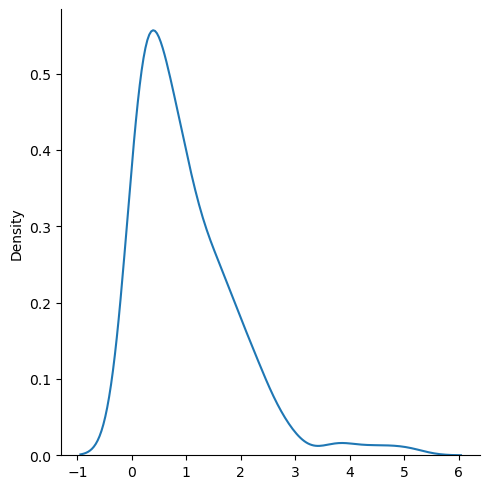

In [3]:
def make_simulated_y(data, snr=0, weib_param=1.1, seed=None):
    rng = np.random.RandomState(seed)
    weights = np.random.randn(data.shape[1])
    y_sim = data.dot(weights) * snr + rng.weibull(weib_param, size=data.shape[0])
    return y_sim

y_sim = make_simulated_y(data, snr=0)
sns.displot(y_sim, kind='kde')


Do ridge regression to see how strong the association is.

In [4]:
def run_ridgeCV(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False,
                clf=None):
    ss = ShuffleSplit(n_splits=nsplits,
                      test_size=test_size, random_state=seed)
    r2 = []
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV
        model = clf()
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')

    return np.mean(r2)

run_ridgeCV(data, y_sim)

np.float64(-0.1397930829468842)

Why is the mean r2 negative?

In [5]:

def run_ridgeCV_equaldist(data, target, nsplits=100, test_size=0.3,
                seed=None, verbose=False, splitmult=10000,
                pthresh=.999, clf=None, shuffle_y=False):
    
    ss = ShuffleSplit(n_splits=nsplits*splitmult,
                      test_size=test_size, random_state=seed)
    r2 = []
    if shuffle_y:
        target = np.random.permutation(target)
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        if ks_2samp(target[train_idx], target[test_idx]).pvalue < pthresh:
            continue
        train_X = data[train_idx]
        train_y = target[train_idx]
        test_X = data[test_idx]
        test_y = target[test_idx]

        # fit the model
        if clf is None:
            clf = RidgeCV()
        model = clf
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        r2.append(sklearn.metrics.r2_score(test_y, pred_y))
        if verbose:
            print(f'split {split_idx}: r2={r2[-1]}')
        if len(r2) == nsplits:
            break
    if verbose:
        if len(r2) < nsplits:
            print(f'Warning: only {len(r2)} splits completed on {split_idx} attempts')
        else:
            print(f'Completed {len(r2)} splits on {split_idx} attempts')
    return np.mean(r2)

run_ridgeCV_equaldist(data, y_sim, verbose=True)

split 1906: r2=-0.061500063362836865
split 2693: r2=-0.045446808958995444
split 2920: r2=-0.1501461414993206
split 7312: r2=-0.11308438346961114
split 9085: r2=0.009516397413227295
split 9743: r2=-0.014847959682499301
split 10005: r2=-0.04181495783146283
split 10036: r2=-0.20643978542575114
split 12203: r2=-0.0018354208257238547
split 12695: r2=-0.0702568580587255
split 13262: r2=-0.09658062827866032
split 14648: r2=-0.15897312192589075
split 15151: r2=-0.05773635071646677
split 15614: r2=-0.03916751925936812
split 19959: r2=-0.20137695803525113
split 20559: r2=-0.049293539103598016
split 20601: r2=-0.1263702592644529
split 20693: r2=-0.09104406889248606
split 22029: r2=-0.18340695328931966
split 22034: r2=-0.17173588799981676
split 22424: r2=-0.12471344987358801
split 23529: r2=-0.1716431818162676
split 23602: r2=-0.005275057901137359
split 23760: r2=-0.2836104826968926
split 25762: r2=-0.04553049663006292
split 25896: r2=-0.026395817748551043
split 30406: r2=-0.056547054739973346
spl

np.float64(-0.09546500576657335)

Now generate some data with true signal and make sure it works.

### Decoding continuous variables across subjects

Let's decode age from the fMRI data.

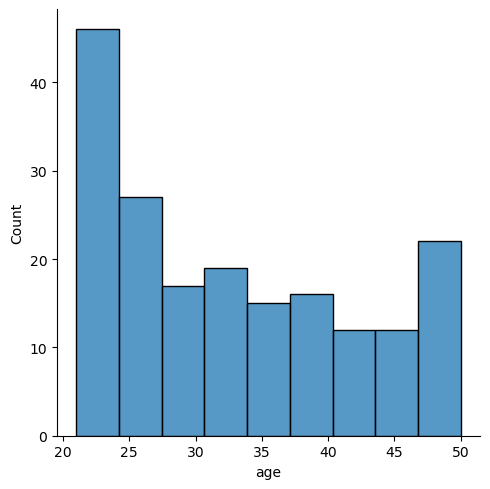

In [6]:
sns.displot(metadata_df[pheno_var])

In [7]:
# use shuffle split

acc = run_ridgeCV_equaldist(data, metadata_df[pheno_var])
print('Mean accuracy:', acc)

shuf_acc = [acc] # include the actual accuracy to preven p=0
for i in range(500):
    shuf_acc.append(run_ridgeCV_equaldist(data, metadata_df[pheno_var], 
                                     shuffle_y=True))
print('p-value under null:', np.mean(acc <= np.array(shuf_acc)))


Mean accuracy: 0.2037588823039524
p-value under null: 0.001996007984031936


### Predict using a nonlinear model

There may be some nonlinear signals, so let's try a neural network.

In [8]:
from CNNModel import CNNModel

cope = contrast_dict[task][contrast]
taskdir = basedir / 'combined' / task 
data_img = nib.load(taskdir/ f'cope{cope}_combat.nii.gz')

model = CNNModel(
    input_shape=[1],
    out_shape=data_img.get_fdata().shape[:3],
    num_classes=1,
)

model.to(device)
print(model)

CNNModel(
  (model): Sequential(
    (0): Conv3d(1, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout3d(p=0.1, inplace=False)
    (4): Conv3d(8, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2))
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout3d(p=0.1, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=19040, out_features=1, bias=True)
  )
)


In [9]:
def get_dataloaders(train_idx, test_idx, task, contrast, labels, batch_size=50,
                    onehot=False, noise_sd=0):
    cope = contrast_dict[task][contrast]
    taskdir = basedir / 'combined' / task 
    data_img = nib.load(taskdir/ f'cope{cope}_combat.nii.gz')
    
    data = einops.rearrange(data_img.get_fdata(), 'x y z s -> s 1 x y z')
    if noise_sd > 0:
        data += np.random.randn(*data.shape) * noise_sd
    data_tensor = torch.tensor(data.astype('float32')).to(device).to(torch.float32)
    labels = np.array(labels).reshape(-1, 1)
    if onehot:
        enc = OneHotEncoder(handle_unknown='ignore')
        labels_tensor = torch.tensor(enc.fit_transform(labels).toarray().astype('float32')).to(device).to(torch.float32)
    else:
        labels_tensor = torch.tensor(labels.astype('float32')).to(device).to(torch.float32)
    Dataset_train = TensorDataset(data_tensor[train_idx], labels_tensor[train_idx])
    Loader_train = DataLoader(Dataset_train, batch_size=batch_size, shuffle=True)

    Dataset_test = TensorDataset(data_tensor[test_idx], labels_tensor[test_idx])
    Loader_test = DataLoader(Dataset_test, batch_size=batch_size, shuffle=True)
    return Loader_train, Loader_test

Loader_train, Loader_test = get_dataloaders([1,2,3], [4,5,6], task, contrast,
                                             metadata_df.age)
print(Loader_train.dataset.tensors[0].shape)
Loader_train.dataset.tensors[1].shape



torch.Size([3, 1, 65, 77, 49])


torch.Size([3, 1])

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    lossvals = []

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        lossvals.append(loss.detach().cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(lossvals)



def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, r2 = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    lossvals = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            lossvals.append(loss.detach().cpu().item())
            r2 += sklearn.metrics.r2_score(pred.cpu(), y.cpu())
            #correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    r2 /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return np.mean(lossvals), r2




In [11]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
        model.parameters(),
        lr=.0005
    )
nepochs = 1000
pthresh = .99

target = metadata_df.age
# get a shuffle split with a very similar disribution
ss = ShuffleSplit(n_splits=1000, test_size=.25, random_state=None)
bad_split = True
while bad_split:
    for split_idx, (train_idx, test_idx) in enumerate(ss.split(data)):
        if ks_2samp(target[train_idx], target[test_idx]).pvalue > pthresh:
            bad_split = False

train_loss = []
test_loss = []
test_r2 = []

for epoch in range(nepochs):
    Loader_train, Loader_test = get_dataloaders(
        train_idx, test_idx, task, contrast, target,
        batch_size=30, noise_sd=.0)

    train_loss.append(train_loop(Loader_train, model, loss_fn, optimizer))
    t_loss, t_r2 = test_loop(Loader_test, model, loss_fn)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: test loss={t_loss}, test r2={t_r2}')
    test_loss.append(t_loss)
    test_r2.append(t_r2)



Epoch 0: test loss=614.2785034179688, test r2=-6.626551640101398
Epoch 100: test loss=82.05704498291016, test r2=-0.61571841993601
Epoch 200: test loss=86.08361434936523, test r2=-0.41516935693841117
Epoch 300: test loss=96.97964477539062, test r2=-0.4506003816658465
Epoch 400: test loss=79.82077217102051, test r2=-0.42983803334543036
Epoch 500: test loss=86.82011413574219, test r2=-0.3217440841641127
Epoch 600: test loss=73.52952766418457, test r2=-0.40853128486708934
Epoch 700: test loss=88.84115982055664, test r2=-0.3740197573421688
Epoch 800: test loss=102.96236419677734, test r2=-0.44086040934678566
Epoch 900: test loss=86.71345901489258, test r2=-0.3646894877705837


Text(0.5, 0, 'epoch')

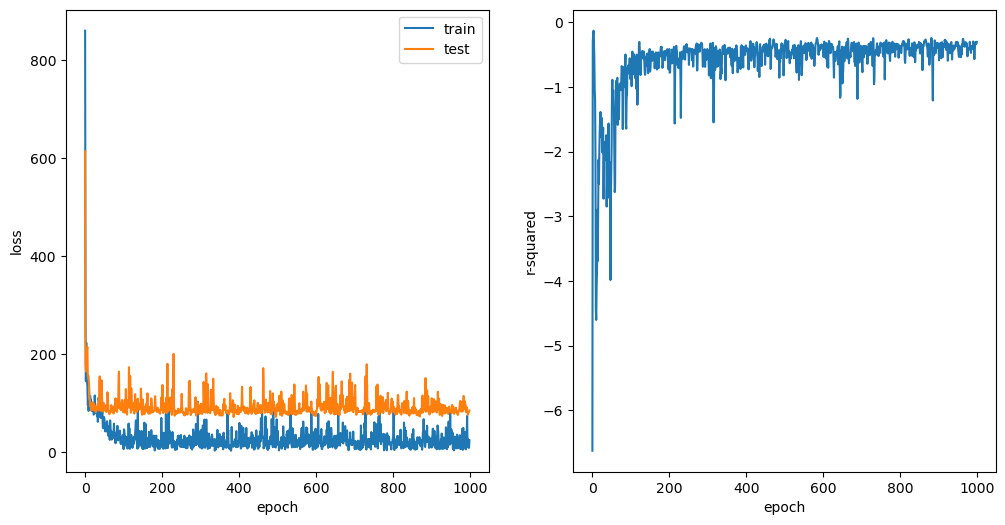

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(test_r2)
plt.ylabel('r-squared')
plt.xlabel('epoch')
